# Delaunay
Here, we'll perform various analysis by constructing graphs and measure properties of those graphs to learn more about the data

In [1]:
import csv
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.spatial import Delaunay
import numpy as np
import math
import skimage
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import future
import networkx as nx
from ragGen import *
%matplotlib inline
sns.set_color_codes("pastel")
from scipy.signal import argrelextrema

In [2]:
# Read in the data
data = open('../../data/data.csv', 'r').readlines()
fieldnames = ['x', 'y', 'z', 'unmasked', 'synapses']
reader = csv.reader(data)
reader.next()

rows = [[int(col) for col in row] for row in reader]

# These will come in handy later
sorted_x = sorted(list(set([r[0] for r in rows])))
sorted_y = sorted(list(set([r[1] for r in rows])))
sorted_z = sorted(list(set([r[2] for r in rows])))

We'll start with just looking at analysis in euclidian space, then thinking about weighing by synaptic density later. Since we hypothesize that our data will show that tissue varies as we move down the y-axis (z-axis in brain) through cortical layers, an interesting thing to do would be compare properties of the graphs on each layer (ie how does graph connectivity vary as we move through layers).

Let's start by triangulating our data. We'll use Delaunay on each y layer first. Putting our data in the right format for doing graph analysis...

In [3]:
a = np.array(rows)
b = np.delete(a, np.s_[3::],1)

# Separate layers - have to do some wonky stuff to get this to work
b = sorted(b, key=lambda e: e[1])
b = np.array([v.tolist() for v in b])
b = np.split(b, np.where(np.diff(b[:,1]))[0]+1)

Now that our data is in the right format, we'll create 52 delaunay graphs. Then we'll perform analyses on these graphs. A simple but useful metric would be to analyze edge length distributions in each layer.

In [4]:
graphs = []
centroid_list = []

for layer in b:
    centroids = np.array(layer)
    
    # get rid of the y value - not relevant anymore
    centroids = np.delete(centroids, 1, 1)
    centroid_list.append(centroids)
    
    graph = Delaunay(centroids)
    graphs.append(graph)

We're going to need a method to get edge lengths from 2D centroid pairs

In [5]:
def get_d_edge_length(edge):
    (x1, y1), (x2, y2) = edge
    return math.sqrt((x2-x1)**2 + (y2-y1)**2)

In [6]:
edge_length_list = [[]]
tri_area_list = [[]]

for del_graph in graphs:
    
    tri_areas = []
    edge_lengths = []
    triangles = []

    for t in centroids[del_graph.simplices]:
        triangles.append(t)
        a, b, c = [tuple(map(int,list(v))) for v in t]
        edge_lengths.append(get_d_edge_length((a,b)))
        edge_lengths.append(get_d_edge_length((a,c)))
        edge_lengths.append(get_d_edge_length((b,c)))
        try:
            tri_areas.append(float(Triangle(a,b,c).area))
        except:
            continue
    edge_length_list.append(edge_lengths)
    tri_area_list.append(tri_areas)

Realizing after all this that simply location is useless. We know the voxels are evenly spaced, which means our edge length data will be all the same. See that the "centroids" are no different:

In [7]:
np.subtract(centroid_list[0], centroid_list[1])

array([[0, 0],
       [0, 0],
       [0, 0],
       ..., 
       [0, 0],
       [0, 0],
       [0, 0]])

There is no distance between the two. Therefore it is perhaps more useful to consider a graph that considers node weights. Voronoi is dual to Delaunay, so that's not much of an option. We want something that considers both spacial location and density similarity. 

### Drawing Graphs

First we look at the default networkx graph plotting:

In [11]:
real_volume = np.zeros((len(sorted_x), len(sorted_y), len(sorted_z)))
for r in rows:
    real_volume[sorted_x.index(r[0]), sorted_y.index(r[1]), sorted_z.index(r[2])] = r[-1]

In [14]:
nx_graphs = []
for layer in b:
    G = nx.Graph(graph)
    nx_graphs.append(G)

NetworkXError: Input is not a known data type for conversion.

TypeError: object of type 'Delaunay' has no len()

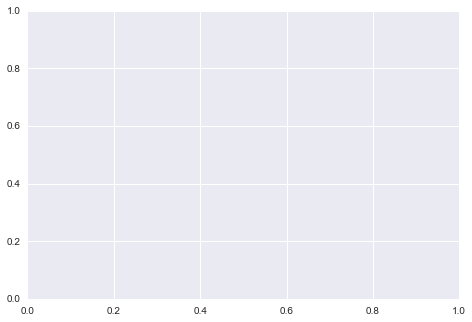

In [15]:
for graph in graphs:
    plt.figure()
    nx.draw(graph, node_size=100)

This is using the spring layout, so we're losing positional information. We can improve the plot by adding position information.

## Self Loops

In [ ]:
num_self_loops = []
for rag in y_rags:
    num_self_loops.append(rag.number_of_selfloops())

In [ ]:
num_self_loops

Interesting. There are no self loops. Why would this be? Let's come back to this. In the meantime, I want to give some though to what it means to have a self loop, whether it should be theoretically possible given our data, and whether our graphs are formed properly.

The answer to this question is very simple. In a RAG, there are no self-loops by definition. Self loops are edges that form a connection between a node and itself.

<img src="../../docs/figures/selfloop.png" width="100">

To see whether the graphs are formed properly, let's look at an adjacency lists:

In [ ]:
# y_rags[0].adjacency_list()

Compare that to the test data:

In [ ]:
# Test Data
test = np.array([[1,2],[3,4]])
test_rag = skimage.future.graph.RAG(test)
test_rag.adjacency_list()

### X-Layers

In [ ]:
real_volume_x = np.zeros((len(sorted_x), len(sorted_y), len(sorted_z)))
for r in rows:
    real_volume_x[ sorted_x.index(r[0]), sorted_y.index(r[1]), sorted_z.index(r[2])] = r[-1]

In [ ]:
x_rags = []
count = 0;
for layer in real_volume_x:
    count = count + 1
    x_rags.append(skimage.future.graph.RAG(layer))

In [ ]:
num_edges_x = []
for rag in x_rags:
    num_edges_x.append(rag.number_of_edges())

In [ ]:
sns.barplot(x=range(len(num_edges_x)), y=num_edges_x)
sns.plt.show()

We can see here the number of edges is low in that area that does not have many synapses. It, as expected, mirrors the distribution of synapses. It appears to be approximately uniform at the top, with buffers of very few synapses on the sides. Remember from here:

In [ ]:
plt.imshow(np.amax(real_volume, axis=2), interpolation='nearest')
plt.show()

In [ ]:
# edge_length_list[3]
# tri_area_list[3]
# triangles

In [ ]:
# Note for future
# del_features['d_edge_length_mean'] = np.mean(edge_lengths)
# del_features['d_edge_length_std'] = np.std(edge_lengths)
# del_features['d_edge_length_skew'] = scipy.stats.skew(edge_lengths)
# del_features['d_edge_length_kurtosis'] = scipy.stats.kurtosis(edge_lengths)